In [1]:
import sys
sys.path.append("..")
import speech_recognition.helper as helper

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

D:\Miniconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading and Reshaping Data

We'll start again by reading in the data we extracted earlier. We'll still only be reading in the command words as these are what the neural network will be trained on.

In [2]:
X_train, y_train = helper.get_fold_data('train', helper.COMMAND_WORDS)
X_val, y_val = helper.get_fold_data('validation', helper.COMMAND_WORDS)
X_test, y_test = helper.get_fold_data('test', helper.COMMAND_WORDS)

print('Number of training samples: {}'.format(len(X_train)))
print('Number of validation samples: {}'.format(len(X_val)))
print('Number of testing samples: {}'.format(len(X_test)))
print('Shape of each sample: {}'.format(X_train[0].shape))

Number of training samples: 34069
Number of validation samples: 4153
Number of testing samples: 4524
Shape of each sample: (20, 32)


In [3]:
#holds counts of each word for each fold
word_counts = pd.DataFrame()
for fold, y in zip(['train', 'validation', 'test'], [y_train, y_val, y_test]):
    word_counts[fold] = pd.Series(y).value_counts()
word_counts = word_counts.sort_index()
word_counts

,train,validation,test
down,3134,377,406
go,3106,372,402
left,3037,352,412
no,3130,406,405
off,2970,373,402
on,3086,363,396
right,3019,363,396
silence,3300,450,450
stop,3111,350,411
up,2948,350,425


Now that we've loaded in the data, we'll need to follow the same process of reformatting it a little so that we can feed it into our neural networks. For the y values, we'll need to transform the labelled words into one hot encoded integers. We'll also need to reshape the X values so that it can be treated as an image.

In [4]:
X_train_img = helper.reformat_X(X_train)
X_val_img = helper.reformat_X(X_val)
X_test_img = helper.reformat_X(X_test)

y_train_hot = helper.reformat_y(y_train)
y_val_hot = helper.reformat_y(y_val)
y_test_hot = helper.reformat_y(y_test)
    
print('X_train shape: {}'.format(X_train_img.shape))
print('y_train_hot shape: {}'.format(y_train_hot.shape))

X_train shape: (34069, 20, 32, 1)
y_train_hot shape: (34069, 11)


# Convolutional Neural Network

Let's see how a convolutional neural network performs on the data. We'll need to flatten the X values and normalize them first so that the optimizer won't get stuck. For this model, we'll be using the default Adam optimizer. We'll also add an early stopping monitor so that the model stops running once the validation loss hasn't decreased in 3 epochs.

In [5]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train_img[0].shape)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(512, kernel_size=(2, 2), activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train_img, y_train_hot, batch_size=128, epochs=30, verbose=1,
          validation_data=(X_val_img, y_val_hot), callbacks=[EarlyStopping(patience=3)])

Train on 34069 samples, validate on 4153 samples
Epoch 1/30
34069/34069 [==============================] - 11s 321us/step - loss: 1.1359 - acc: 0.5976 - val_loss: 0.5188 - val_acc: 0.8358
Epoch 2/30
34069/34069 [==============================] - 8s 246us/step - loss: 0.5624 - acc: 0.8104 - val_loss: 0.3539 - val_acc: 0.8760
Epoch 3/30
34069/34069 [==============================] - 8s 243us/step - loss: 0.4260 - acc: 0.8569 - val_loss: 0.3332 - val_acc: 0.8827
Epoch 4/30
34069/34069 [==============================] - 8s 244us/step - loss: 0.3665 - acc: 0.8767 - val_loss: 0.2573 - val_acc: 0.9143
Epoch 5/30
34069/34069 [==============================] - 8s 246us/step - loss: 0.3223 - acc: 0.8919 - val_loss: 0.2414 - val_acc: 0.9160
Epoch 6/30
34069/34069 [==============================] - 8s 243us/step - loss: 0.2857 - acc: 0.9033 - val_loss: 0.2302 - val_acc: 0.9229
Epoch 7/30
34069/34069 [==============================] - 8s 244us/step - loss: 0.2651 - acc: 0.9111 - val_loss: 0.1962 - 

In [6]:
score = model.evaluate(x=X_test_img, y=y_test_hot)

for name, value in zip(model.metrics_names, score):
    print(name, value)

4524/4524 [==============================] - 0s 104us/step
loss 0.1942735537129769
acc 0.9365605658709107


We already see an improvement in accuracy from our feedforward neural network from ~81% to ~93%. The loss also decreased from ~0.62 to ~0.21.

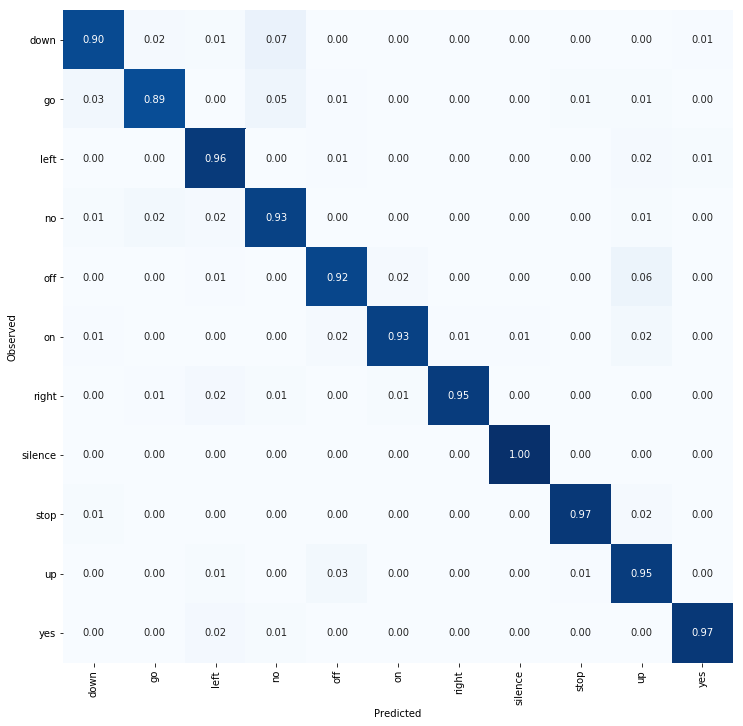

In [7]:
y_pred_val = model.predict_classes(x=X_val_img)
helper.plot_confusion_matrix(y_val, y_pred_val);

This confusion matrix shows us more clearly the vast improvements the CNN has over the simpler models. It's starting to approach the ideal confusion matrix of a straight line down the main diagonal. Still, it has the most trouble classifying "no" and "go," often confusing them for each other or predicting them to be "down." Hopefully, adding in augmented data later will help decrease these misclassifications further.

# Adding Unknown Detection

One last feature the models have been missing so far is to classify words not in the command set as "unknown." We could train it on the 25 words not in the command words set, and label them as unknown. This would work with the data we're given, but we want it to be able to predict any given word or noise it doesn't understand as unknown. One way of doing this is to train on the command words and to validate and test on the entire sample set, classifying any words under a certain confidence threshold as "unknown." We can then tune this confidence threshold to maximize accuracy, or maybe minimize false positive rate depending on which metric is considered more important.

Let's start by testing on the entire dataset and seeing what distribution of confidences our model is giving for words it classifies correctly, those in the command words set it misclassifies, and unknown words.

In [8]:
#reading in entire dataset
X_train_total, y_train_total = helper.get_fold_data('train')
X_val_total, y_val_total = helper.get_fold_data('validation')
X_test_total, y_test_total = helper.get_fold_data('test')

X_img_total = {'train': helper.reformat_X(X_train_total),
              'val': helper.reformat_X(X_val_total),
              'test': helper.reformat_X(X_test_total)}

y_obs_total = {'train': y_train_total,
               'val': y_val_total,
               'test': y_test_total}

#predicting probabilities and classes on entire dataset
y_pred_proba_total = {'train': model.predict(X_img_total['train']),
                      'val': model.predict(X_img_total['val']),
                      'test': model.predict(X_img_total['test'])}


y_pred_classes_total = {'train': model.predict_classes(X_img_total['train']),
                        'val': model.predict_classes(X_img_total['val']),
                        'test': model.predict_classes(X_img_total['test'])}

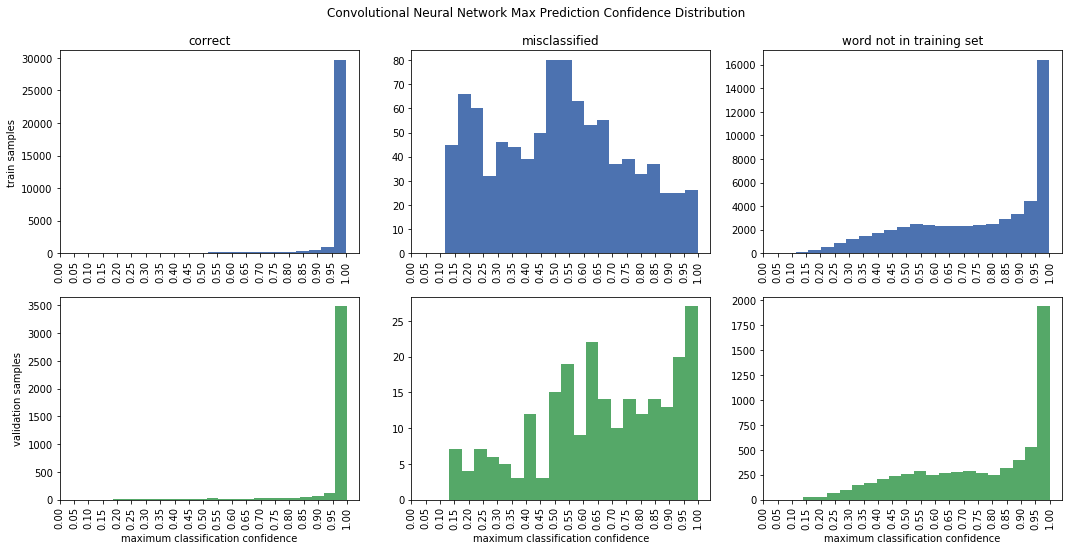

In [9]:
helper.plot_hist_grid(y_obs_total, y_pred_proba_total, y_pred_classes_total,
                      title='Convolutional Neural Network Max Prediction Confidence Distribution');

The convolutional neural network tends to be very confident in its predictions for correctly classified words. For words it knows that it misclassifies, the model can be anywhere from not confident at all to very confident. For words outside the command words set, the model tends to predict with very high confidence most of the time, but can also predict with low and medium confidence fairly frequently as well. Again, this could be due to the words sounding familiar to ones it does know (e.g. "nine" and "no").

Based on the histograms above, we will want to set our threshold for predicting as unknown right around .95. This will eliminate most of the misclassified words it should know (the kind of error we want to avoid the most) without removing too many of the correctly classified words.

train accuracy: 0.7583926120054911
val accuracy: 0.7426900584795322
test accuracy: 0.7470100392841554


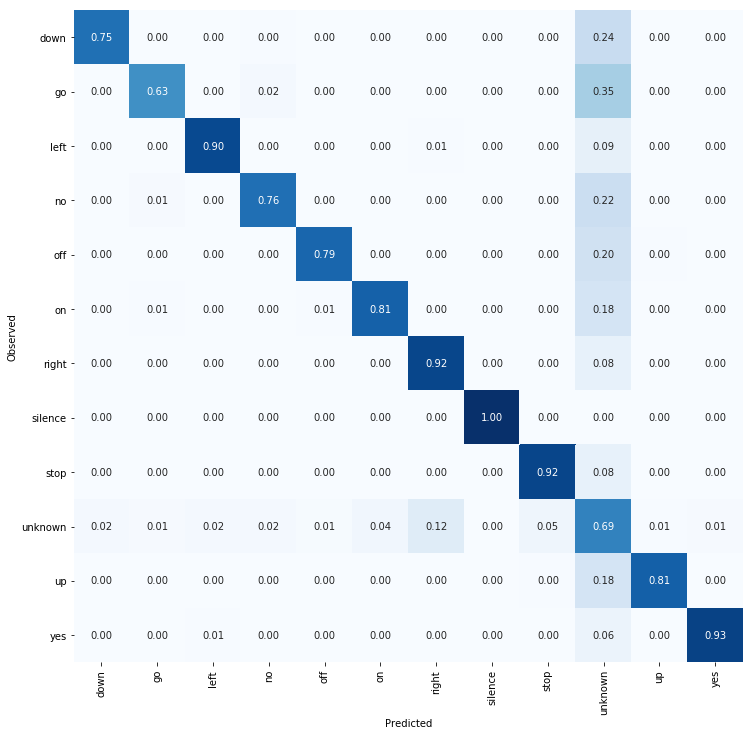

In [10]:
#reclassifying words with a threshold less than .95 as 'unknown'
y_pred_modified = {
    fold: helper.modify_pred_classes(y_pred_proba_total[fold],
                                     y_pred_classes_total[fold], thresh=.95)
    for fold in ['train', 'val', 'test']
}

#calculating new accuracy
for fold in ['train', 'val', 'test']:
    print(fold, 'accuracy:', helper.score_with_unknown(y_obs_total[fold], y_pred_modified[fold]))

helper.plot_confusion_matrix(y_obs_total['test'], y_pred_modified['test'], words=helper.COMMAND_WORDS+['unknown']);

Although we only have an accuracy of around 76% across the folds, the accuracy for most individual word is considerably higher than that. This is because of the large class disparity - over half of the total words are 'unknown'. These words are bringing down the overall accuracy. Still, we have very few other false positives. For command words, the model tends to predict them correctly or as unknown when it's not confident enough. This is exactly how we want it to behave.

This model works well enough that we could stop here. Still, it has a hard time classifying the words "no," "go," and "down." Looking forward, we will want to add augmented data for these words to help it classify them and improve performance further.